# Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/training.ipynb)

In [35]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

# Import packages

In [36]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

from chemprop import data, featurizers, models, nn

# Change data inputs here

In [37]:
from google.colab import drive
drive.mount('/content/drive')
input_path = "/content/drive/MyDrive/chemprop/train.csv"
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['target'] # list of names of the columns containing targets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [38]:
df_input = pd.read_csv(input_path)
df_input

,smiles,target
0,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,1
1,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,1
2,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,1
3,Cl.N=C(N)n1cccn1,1
4,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,1
...,...,...
2330,C=CC1(C)CC(=O)C2(O)C(C)(O1)C(OC(C)=O)C(O)C1C(C...,0
2331,O=S(=O)([O-])c1cc(O)c2c(N=Nc3ccc(Nc4ccccc4)c4c...,0
2332,Nc1ccc(S(=O)(=O)c2ccc(N)cc2)cc1,0
2333,Cc1cc(-c2ccc(N=Nc3ccc4c(S(=O)(=O)[O-])cc(S(=O)...,0


## Get SMILES and targets

In [39]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [40]:
smis[:5] # show first 5 SMILES strings

array(['Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(CSc4nnnn4C)CSC23)c2ccc(O)cc2)cn1',
       'CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1CN.CS(=O)(=O)O',
       'CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O)NC1CCNC(=O)C(C(C)O)NC(=O)C(CCN)NC(=O)C(CCN)NC(=O)C(CC(C)C)NC(=O)C(Cc2ccccc2)NC(=O)C(CCN)NC1=O)C(C)O.O=S(=O)(O)O',
       'Cl.N=C(N)n1cccn1',
       'Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(=N)Nc1ccc(Cl)cc1'],
      dtype=object)

In [41]:
ys[:5] # show first 5 targets

array([[1],
       [1],
       [1],
       [1],
       [1]])

## Get molecule datapoints

In [42]:
all_data = []
for smi, y in zip(smis, ys):
    try:
        datapoint = data.MoleculeDatapoint.from_smi(smi, y)
        all_data.append(datapoint)
    except RuntimeError as e:
        print(f"Skipping invalid SMILES: {smi} due to error: {e}")

Skipping invalid SMILES: O=S(=O)(OCC1OC(OC2(COS(=O)(=O)O[AlH3](O)O)OC(COS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C2OS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C1OS(=O)(=O)O[AlH3](O)O)O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O due to error: SMILES O=S(=O)(OCC1OC(OC2(COS(=O)(=O)O[AlH3](O)O)OC(COS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C2OS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C(OS(=O)(=O)O[AlH3](O)O)C1OS(=O)(=O)O[AlH3](O)O)O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O.O[AlH3](O)O is invalid! (RDKit returned None)


[09:18:43] Explicit valence for atom # 16 Al, 6, is greater than permitted


## Perform data splitting for training, validation, and testing

In [43]:
# available split types
list(data.SplitType.keys())

['SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

Chemprop's `make_split_indices` function will always return a two- (if no validation) or three-length tuple.
Each member is a list of length `num_replicates`.
The inner lists then contain the actual indices for splitting.

The type signature for this return type is `tuple[list[list[int]], ...]`.

In [44]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

Chemprop's splitting function implements our preferred method of data splitting, which is random replication.
It's also possible to add your own custom cross-validation splitter, such as one of those as implemented in scikit-learn, as long as you get the data into the same `tuple[list[list[int]], ...]` data format with something like this:

In [45]:
from sklearn.model_selection import KFold

k_splits = KFold(n_splits=5)
k_train_indices, k_val_indices, k_test_indices = [], [], []
for fold in k_splits.split(mols):
    k_train_indices.append(fold[0])
    k_val_indices.append([])
    k_test_indices.append(fold[1])
k_train_data, _, k_test_data = data.split_data_by_indices(
    all_data, k_train_indices, None, k_test_indices
)

## Get MoleculeDataset
Recall that the data is in a list equal in length to the number of replicates, so we select the zero index of the list to get the first replicate.

In [46]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
# scaler = train_dset.normalize_targets() # No target normalization for classification

val_dset = data.MoleculeDataset(val_data[0], featurizer)
# val_dset.normalize_targets(scaler) # No target normalization for classification

test_dset = data.MoleculeDataset(test_data[0], featurizer)

## Get DataLoader

In [47]:
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

# Change Message-Passing Neural Network (MPNN) inputs here

## Message Passing
A `Message passing` constructs molecular graphs using message passing to learn node-level hidden representations.

Options are `mp = nn.BondMessagePassing()` or `mp = nn.AtomMessagePassing()`

In [48]:
mp = nn.BondMessagePassing()

## Aggregation
An `Aggregation` is responsible for constructing a graph-level representation from the set of node-level representations after message passing.

Available options can be found in ` nn.agg.AggregationRegistry`, including
- `agg = nn.MeanAggregation()`
- `agg = nn.SumAggregation()`
- `agg = nn.NormAggregation()`

In [49]:
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [50]:
agg = nn.MeanAggregation()

## Feed-Forward Network (FFN)

A `FFN` takes the aggregated representations and make target predictions.

Available options can be found in `nn.PredictorRegistry`.

For regression:
- `ffn = nn.RegressionFFN()`
- `ffn = nn.MveFFN()`
- `ffn = nn.EvidentialFFN()`

For classification:
- `ffn = nn.BinaryClassificationFFN()`
- `ffn = nn.BinaryDirichletFFN()`
- `ffn = nn.MulticlassClassificationFFN()`
- `ffn = nn.MulticlassDirichletFFN()`

For spectral:
- `ffn = nn.SpectralFFN()` # will be available in future version

In [51]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [52]:
# output_transform = nn.UnscaleTransform.from_standard_scaler(scaler) # Not needed for classification

In [53]:
ffn = nn.BinaryClassificationFFN()

## Batch Norm
A `Batch Norm` normalizes the outputs of the aggregation by re-centering and re-scaling.

Whether to use batch norm

In [54]:
batch_norm = True

## Metrics
`Metrics` are the ways to evaluate the performance of model predictions.

Available options can be found in `metrics.MetricRegistry`, including

In [55]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


In [56]:
metric_list = [nn.metrics.BinaryAUROC(), nn.metrics.BinaryAccuracy(), nn.metrics.BinaryF1Score()]

## Constructs MPNN

In [57]:
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): BinaryClassificationFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): BCELoss(task_weights=[[1.0]])
    (output_transform): Identity()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): BinaryAUROC()
    (1): BinaryAccuracy()
    

# Set up trainer

In [58]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)


trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20, # number of epochs to train for
    callbacks=[checkpointing], # Use the configured checkpoint callback
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


# Start training

In [59]:
# @title AI prompt cell

import ipywidgets as widgets
from IPython.display import display, HTML, Markdown,clear_output
from google.colab import ai

dropdown = widgets.Dropdown(
    options=[],
    layout={'width': 'auto'}
)

def update_model_list(new_options):
    dropdown.options = new_options
update_model_list(ai.list_models())

text_input = widgets.Textarea(
    placeholder='Ask me anything....',
    layout={'width': 'auto', 'height': '100px'},
)

button = widgets.Button(
    description='Submit Text',
    disabled=False,
    tooltip='Click to submit the text',
    icon='check'
)

output_area = widgets.Output(
     layout={'width': 'auto', 'max_height': '300px','overflow_y': 'scroll'}
)

def on_button_clicked(b):
    with output_area:
        output_area.clear_output(wait=False)
        accumulated_content = ""
        for new_chunk in ai.generate_text(prompt=text_input.value, model_name=dropdown.value, stream=True):
            if new_chunk is None:
                continue
            accumulated_content += new_chunk
            clear_output(wait=True)
            display(Markdown(accumulated_content))

button.on_click(on_button_clicked)
vbox = widgets.GridBox([dropdown, text_input, button, output_area])

display(HTML("""
<style>
.widget-dropdown select {
    font-size: 18px;
    font-family: "Arial", sans-serif;
}
.widget-textarea textarea {
    font-size: 18px;
    font-family: "Arial", sans-serif;
}
</style>
"""))
display(vbox)


GridBox(children=(Dropdown(layout=Layout(width='auto'), options=('google/gemini-2.5-flash', 'google/gemini-2.5…

In [60]:
trainer.fit(mpnn, train_loader, val_loader)

INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type                    ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing      │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation         │      0 │ train │     0 │
│ 2 │ bn              │ BatchNorm1d             │    600 │ train │     0 │
│ 3 │ predictor       │ BinaryClassificationFFN │ 90.6 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity                │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList              │      0 │ train │     0 │
└───┴─────────────────┴─────────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 26                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Test results

In [61]:
results = trainer.test(dataloaders=test_loader, ckpt_path='best', weights_only=False)

INFO: Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=8-val_loss=0.13.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=8-val_loss=0.13.ckpt
INFO: Loaded model weights from the checkpoint at /content/chemprop/examples/checkpoints/best-epoch=8-val_loss=0.13.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/chemprop/examples/checkpoints/best-epoch=8-val_loss=0.13.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9743589758872986     │
│          test/f1          │    0.4000000059604645     │
│         test/roc          │    0.7809734344482422     │
└───────────────────────────┴───────────────────────────┘

Output()

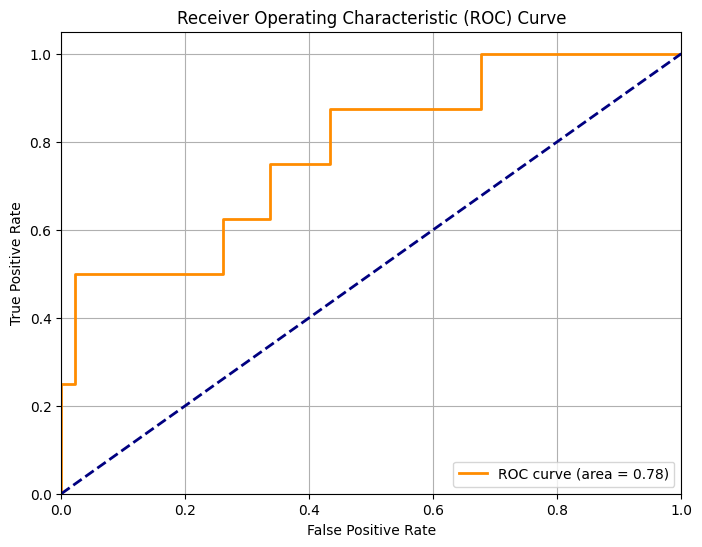

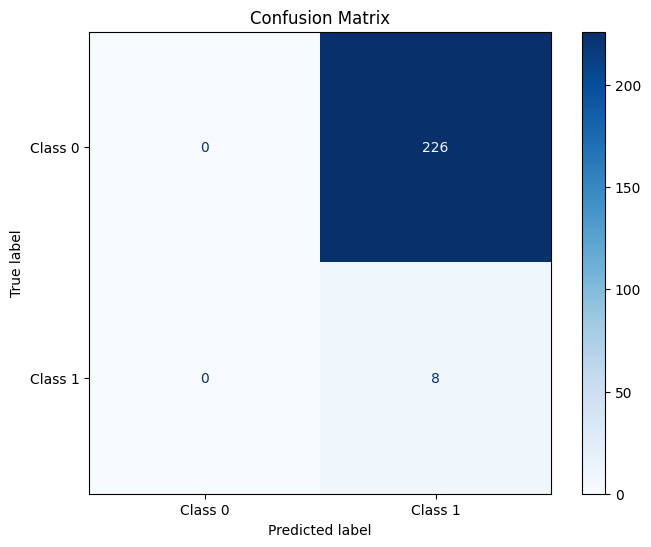

--- Test Metrics ---
Test AUROC: 0.7810
Test Accuracy: 0.9744
Test F1-Score: 0.4000


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Get raw logits from the model on the test set
# trainer.predict returns a list of batch outputs. Each batch output is a tensor of logits.
logits_batches = trainer.predict(mpnn, dataloaders=test_loader)
all_logits = torch.cat(logits_batches, dim=0).cpu().numpy()

# Get true labels directly from the test_dset
all_true_labels = np.concatenate([d.y for d in test_dset], axis=0)

# Apply sigmoid to logits to get probabilities
all_probs = torch.sigmoid(torch.from_numpy(all_logits)).numpy()

# Flatten if necessary (for single-task classification, target might be [[0], [1]])
if all_true_labels.ndim > 1 and all_true_labels.shape[1] == 1:
    all_true_labels = all_true_labels.flatten()
if all_probs.ndim > 1 and all_probs.shape[1] == 1:
    all_probs = all_probs.flatten()

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5
all_binary_preds = (all_probs >= threshold).astype(int)

# --- Visualization 1: ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_true_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Visualization 2: Confusion Matrix ---
cm = confusion_matrix(all_true_labels, all_binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']) # Assuming classes are 0 and 1

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Print the test metrics obtained earlier
print("--- Test Metrics ---")
print(f"Test AUROC: {results[0]['test/roc']:.4f}")
print(f"Test Accuracy: {results[0]['test/accuracy']:.4f}")
print(f"Test F1-Score: {results[0]['test/f1']:.4f}")